# Семинар 1 — BM25 и гибридный поиск

-----

### **Цель семинара**

На этом семинаре мы реализуем алгоритм **BM25** с нуля, построим **инвертированный индекс**, создадим **гибридный поиск** (BM25 + векторный), и сравним нашу реализацию с промышленным решением **Elasticsearch**.

**После семинара вы будете:**
- Понимать математику BM25 и уметь реализовывать его с нуля
- Строить эффективные инвертированные индексы
- Комбинировать лексический и семантический поиск
- Оценивать качество поисковых систем

-----

### **0. Установка и импорт библиотек**

In [2]:
# # Установка необходимых библиотек
# !pip install sentence-transformers  # для векторного поиска
# !pip install faiss-cpu             # для быстрого поиска ближайших соседей (совместимая с windows версия)
# !pip install rank-bm25             # для сравнения с готовой реализацией
# !pip install pymorphy3 pymorphy3-dicts-ru  # для обработки русского текста
# !pip install tqdm

In [1]:
import re
import math
import time
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from collections import defaultdict, Counter
from typing import List, Dict, Tuple, Optional
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import pymorphy3
from sentence_transformers import SentenceTransformer
import faiss
from rank_bm25 import BM25Okapi

warnings.filterwarnings('ignore')

In [2]:
# Загрузка ресурсов NLTK
nltk.download('punkt')
nltk.download('stopwords')

# Инициализируем морфологический анализатор
morph = pymorphy3.MorphAnalyzer()

# Русские стоп-слова
stop_words_ru = set(stopwords.words('russian'))
print(f"Загружено {len(stop_words_ru)} стоп-слов")

Загружено 151 стоп-слов


[nltk_data] Downloading package punkt to /Users/nfox/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/nfox/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


-----

### **1. Загрузка и подготовка данных**

Мы будем работать с коллекцией научных статей или документации. Для демонстрации создадим небольшой корпус.


Статистика корпуса:
Средняя длина документа: 90.2 слов
Медианная длина: 65.0 слов
Мин/Макс: 4/1671 слов


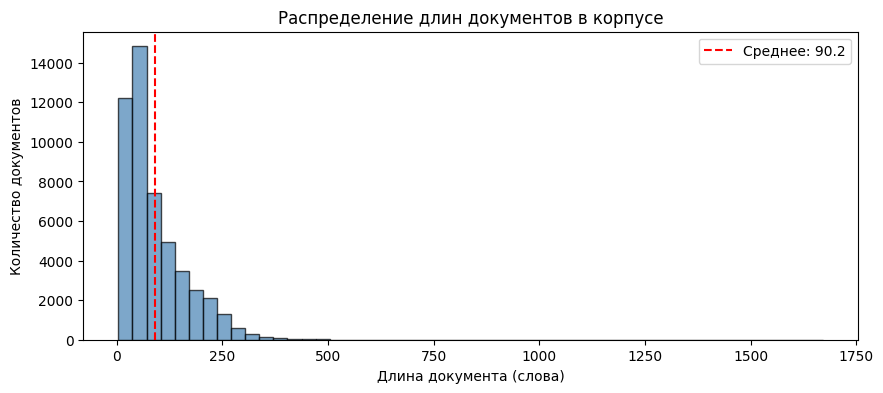

In [3]:
# Загружаем корпус документов
# Для демонстрации используем датасет AIR-Bench/qa_science_ru

splits = {'corpus_default': 'AIR-Bench_24.05/default/corpus.jsonl',
          'queries_default_dev': 'AIR-Bench_24.05/default/dev_queries.jsonl',
          'queries_default_test': 'AIR-Bench_24.05/default/test_queries.jsonl'}

df = pd.read_json("hf://datasets/AIR-Bench/qa_science_ru/" + splits["corpus_default"], lines=True)
df = df.set_index('id')

documents = df['text'].to_list()[:50000]

# Базовая статистика
doc_lengths = [len(doc.split()) for doc in documents]
print(f"\nСтатистика корпуса:")
print(f"Средняя длина документа: {np.mean(doc_lengths):.1f} слов")
print(f"Медианная длина: {np.median(doc_lengths):.1f} слов")
print(f"Мин/Макс: {min(doc_lengths)}/{max(doc_lengths)} слов")

# Визуализация распределения длин
plt.figure(figsize=(10, 4))
plt.hist(doc_lengths, bins=50, alpha=0.7, color='steelblue', edgecolor='black')
plt.xlabel('Длина документа (слова)')
plt.ylabel('Количество документов')
plt.title('Распределение длин документов в корпусе')
plt.axvline(np.mean(doc_lengths), color='red', linestyle='--', label=f'Среднее: {np.mean(doc_lengths):.1f}')
plt.legend()
plt.show()

-----

### **2. Предобработка текста**

Создадим функции для токенизации и нормализации текста.

In [ ]:
class TextPreprocessor:
    """Класс для предобработки текста"""

    def __init__(self, use_lemma=True, remove_stopwords=True):
        self.use_lemma = use_lemma
        self.remove_stopwords = remove_stopwords
        self.morph = pymorphy3.MorphAnalyzer()
        self.stop_words = set(stopwords.words('russian'))

    def preprocess(self, text: str) -> List[str]:
        """Предобработка текста и возврат списка токенов"""
        # Приводим к нижнему регистру
        text = text.lower()

        # Удаляем HTML и спецсимволы
        text = re.sub(r'<.*?>', ' ', text)
        text = re.sub(r'http\S+', ' ', text)
        text = re.sub(r'[^а-яёa-z0-9\s]', ' ', text)
        text = re.sub(r'\s+', ' ', text)

        # Токенизация
        tokens = text.split()

        # Удаление стоп-слов
        if self.remove_stopwords:
            tokens = [t for t in tokens if t not in self.stop_words]

        # Лемматизация
        if self.use_lemma:
            tokens = [self.morph.parse(t)[0].normal_form for t in tokens]

        # Фильтрация коротких токенов
        tokens = [t for t in tokens if len(t) > 2]

        return tokens

# Создаём препроцессор
preprocessor = TextPreprocessor(use_lemma=True, remove_stopwords=True)

# Пример предобработки
sample_text = "Машинное обучение и нейронные сети революционизировали искусственный интеллект!"
tokens = preprocessor.preprocess(sample_text)
print(f"Исходный текст: {sample_text}")
print(f"После обработки: {tokens}")

# Предобрабатываем весь корпус
print("\nПредобработка корпуса...")
tokenized_docs = [preprocessor.preprocess(doc) for doc in tqdm(documents)]

# Статистика после предобработки
vocab = set()
for doc in tokenized_docs:
    vocab.update(doc)

print(f"\nРазмер словаря: {len(vocab)} уникальных токенов")
print(f"Средняя длина документа после обработки: {np.mean([len(doc) for doc in tokenized_docs]):.1f} токенов")

Исходный текст: Машинное обучение и нейронные сети революционизировали искусственный интеллект!
После обработки: ['машинный', 'обучение', 'нейронный', 'сеть', 'революционизировать', 'искусственный', 'интеллект']

Предобработка корпуса...


  0%|          | 0/50000 [00:00<?, ?it/s]


Размер словаря: 113535 уникальных токенов
Средняя длина документа после обработки: 70.6 токенов


-----

### **3. Реализация BM25 с нуля**

Теперь реализуем алгоритм BM25, включая построение инвертированного индекса.

In [ ]:
class InvertedIndex:
    """Инвертированный индекс для BM25"""

    def __init__(self):
        self.index = defaultdict(list)   # term -> [(doc_id, term_freq, positions)]
        self.doc_lengths = {}            # doc_id -> length
        self.doc_count = 0               # общее количество документов
        self.avg_doc_length = 0          # средняя длина документа
        self.doc_freq = defaultdict(int) # term -> количество документов с термином

    def add_document(self, doc_id: int, tokens: List[str]):
        """Добавление документа в индекс"""
        self.doc_count += 1
        self.doc_lengths[doc_id] = len(tokens)

        # Подсчёт частот и позиций терминов
        term_positions = defaultdict(list)
        term_freqs = Counter(tokens)

        for pos, term in enumerate(tokens):
            term_positions[term].append(pos)

        # Добавление в индекс
        for term, freq in term_freqs.items():
            self.index[term].append({
                'doc_id': doc_id,
                'freq': freq,
                'positions': term_positions[term]
            })
            self.doc_freq[term] += 1

    def build(self, tokenized_docs: List[List[str]]):
        """Построение индекса для корпуса документов"""
        print("Построение инвертированного индекса...")

        for doc_id, tokens in enumerate(tqdm(tokenized_docs)):
            self.add_document(doc_id, tokens)

        # Вычисляем среднюю длину документа
        self.avg_doc_length = sum(self.doc_lengths.values()) / len(self.doc_lengths)

        print(f"Индекс построен: {len(self.index)} терминов, {self.doc_count} документов")
        print(f"Средняя длина документа: {self.avg_doc_length:.2f} токенов")

    def get_posting_list(self, term: str) -> List[Dict]:
        """Получение posting list для термина"""
        return self.index.get(term, [])

    def get_stats(self) -> Dict:
        """Статистика индекса"""
        posting_lengths = [len(postings) for postings in self.index.values()]
        return {
            'total_terms': len(self.index),
            'total_docs': self.doc_count,
            'avg_doc_length': self.avg_doc_length,
            'avg_posting_length': np.mean(posting_lengths) if posting_lengths else 0,
            'max_posting_length': max(posting_lengths) if posting_lengths else 0,
            'memory_size_mb': self._estimate_memory() / (1024 * 1024)
        }

    def _estimate_memory(self) -> int:
        """Оценка использования памяти в байтах"""
        # Грубая оценка
        size = 0
        for term, postings in self.index.items():
            size += len(term) * 2  # Unicode символы
            size += len(postings) * 50  # Примерный размер posting
        return size

# Создаём и строим индекс
index = InvertedIndex()
index.build(tokenized_docs)

# Статистика индекса
stats = index.get_stats()
print("\nСтатистика инвертированного индекса:")
for key, value in stats.items():
    print(f"  {key}: {value:.2f}" if isinstance(value, float) else f"  {key}: {value}")

Построение инвертированного индекса...


  0%|          | 0/50000 [00:00<?, ?it/s]

Индекс построен: 113535 терминов, 50000 документов
Средняя длина документа: 70.63 токенов

Статистика инвертированного индекса:
  total_terms: 113535
  total_docs: 50000
  avg_doc_length: 70.63
  avg_posting_length: 23.61
  max_posting_length: 24167
  memory_size_mb: 129.88


In [ ]:
class BM25:
    """Реализация алгоритма BM25"""

    def __init__(self, index: InvertedIndex, k1: float = 1.2, b: float = 0.75):
        """
        Параметры:
        - k1: параметр насыщения частоты термина (обычно 1.2-2.0)
        - b: параметр нормализации длины документа (обычно 0.75)
        """
        self.index = index
        self.k1 = k1
        self.b = b
        self.idf_cache = {}  # Кэш для IDF значений

    def _compute_idf(self, term: str) -> float:
        """Вычисление IDF для термина"""
        if term in self.idf_cache:
            return self.idf_cache[term]

        N = self.index.doc_count
        df = self.index.doc_freq.get(term, 0)

        if df == 0:
            idf = 0
        else:
            # Формула IDF для BM25
            idf = math.log((N - df + 0.5) / (df + 0.5) + 1)

        self.idf_cache[term] = idf
        return idf

    def score(self, query_tokens: List[str], doc_id: int) -> float:
        """Вычисление BM25 скора для документа"""
        score = 0.0
        doc_length = self.index.doc_lengths.get(doc_id, 0)

        if doc_length == 0:
            return 0.0

        # Нормализация длины документа
        norm_factor = 1 - self.b + self.b * (doc_length / self.index.avg_doc_length)

        # Считаем частоты терминов в документе
        doc_term_freqs = defaultdict(int)
        for term in query_tokens:
            postings = self.index.get_posting_list(term)
            for posting in postings:
                if posting['doc_id'] == doc_id:
                    doc_term_freqs[term] = posting['freq']
                    break

        # Вычисляем скор
        for term in set(query_tokens):  # Уникальные термины запроса
            if term not in doc_term_freqs:
                continue

            idf = self._compute_idf(term)
            tf = doc_term_freqs[term]

            # Формула BM25
            numerator = tf * (self.k1 + 1)
            denominator = tf + self.k1 * norm_factor

            score += idf * (numerator / denominator)

        return score

    def search(self, query: str, top_k: int = 10) -> List[Tuple[int, float]]:
        """Поиск top-k документов для запроса"""
        # Предобработка запроса
        query_tokens = preprocessor.preprocess(query)

        if not query_tokens:
            return []

        # Находим документы-кандидаты (содержащие хотя бы один термин)
        candidate_docs = set()
        for term in query_tokens:
            postings = self.index.get_posting_list(term)
            for posting in postings:
                candidate_docs.add(posting['doc_id'])

        # Вычисляем скоры для кандидатов
        scores = []
        for doc_id in candidate_docs:
            score = self.score(query_tokens, doc_id)
            if score > 0:
                scores.append((doc_id, score))

        # Сортируем по скору и возвращаем top-k
        scores.sort(key=lambda x: x[1], reverse=True)
        return scores[:top_k]

# Создаём экземпляр BM25
bm25 = BM25(index, k1=1.2, b=0.75)

# Тестовые запросы
test_queries = [
    "машинное обучение",
    "нейронные сети трансформеры",
    "дифференциальные уравнения",
    "программирование"
]

print("\nТестирование BM25 поиска:")
print("=" * 50)

for query in test_queries:
    results = bm25.search(query, top_k=3)
    print(f"\nЗапрос: '{query}'")
    print("Топ-3 результата:")

    for doc_id, score in results:
        # Показываем начало документа
        doc_preview = documents[doc_id][:100] + "..."
        print(f"  Doc {doc_id} (score: {score:.3f}): {doc_preview}")


Тестирование BM25 поиска:

Запрос: 'машинное обучение'
Топ-3 результата:
  Doc 37134 (score: 14.769): Преподавателю важно оценивать знания студентов, чтобы оценивать эффективность своих методов преподав...
  Doc 6409 (score: 14.281): Машинное обучение начинает входить в арсенал хакеров, что открывает новые окна возможностей для поте...
  Doc 42158 (score: 13.960): В изложении актуальных методов прогнозирования экономики акцентируется внимание на статистическом ан...

Запрос: 'нейронные сети трансформеры'
Топ-3 результата:
  Doc 22751 (score: 17.780): В статье рассматривается вопросы аппроксимации и интерполяции функций с использованием искусственных...
  Doc 43113 (score: 16.910): Рассматривается применение нейронных сетей для синтеза систем регулирования. Приведены примеры синте...
  Doc 41700 (score: 16.768): Одна из основных проблем, стоящих перед разработчиком системы с нейронной сетью - выбор структуры не...

Запрос: 'Python программирование'
Топ-3 результата:
  Doc 31884 (score:

-----

### **4. Векторный поиск с помощью Sentence Transformers**

Теперь реализуем векторный поиск на основе семантического сходства.

In [ ]:
class VectorSearch:
    """Векторный поиск с использованием Sentence Transformers и FAISS"""

    def __init__(self, model_name: str = 'sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2'):
        print(f"Загрузка модели {model_name}...")
        self.model = SentenceTransformer(model_name, device='cuda')
        self.index = None
        self.documents = None
        self.doc_embeddings = None

    def build_index(self, documents: List[str]):
        """Построение векторного индекса"""
        print("Создание эмбеддингов документов...")
        self.documents = documents

        # Создаём эмбеддинги для всех документов
        self.doc_embeddings = self.model.encode(
            documents,
            show_progress_bar=True,
            convert_to_numpy=True
        )

        # Нормализуем векторы для косинусного сходства
        faiss.normalize_L2(self.doc_embeddings)

        # Создаём FAISS индекс
        dimension = self.doc_embeddings.shape[1]
        self.index = faiss.IndexFlatIP(dimension)  # Inner Product = Cosine similarity после нормализации
        self.index.add(self.doc_embeddings)

        print(f"Векторный индекс построен: {len(documents)} документов, размерность {dimension}")

    def search(self, query: str, top_k: int = 10) -> List[Tuple[int, float]]:
        """Поиск top-k похожих документов"""
        # Создаём эмбеддинг запроса
        query_embedding = self.model.encode([query], convert_to_numpy=True)
        faiss.normalize_L2(query_embedding)

        # Поиск в индексе
        scores, indices = self.index.search(query_embedding, top_k)

        # Возвращаем результаты в формате (doc_id, score)
        results = [(int(idx), float(score)) for idx, score in zip(indices[0], scores[0])]
        return results

# Создаём векторный поиск
vector_search = VectorSearch()
vector_search.build_index(documents)

# Тестируем векторный поиск
print("\nТестирование векторного поиска:")
print("=" * 50)

for query in test_queries:
    results = vector_search.search(query, top_k=3)
    print(f"\nЗапрос: '{query}'")
    print("Топ-3 результата:")

    for doc_id, score in results:
        doc_preview = documents[doc_id][:100] + "..."
        print(f"  Doc {doc_id} (similarity: {score:.3f}): {doc_preview}")

Загрузка модели sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2...


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/645 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/471M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/480 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.08M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Создание эмбеддингов документов...


Batches:   0%|          | 0/1563 [00:00<?, ?it/s]

Векторный индекс построен: 50000 документов, размерность 384

Тестирование векторного поиска:

Запрос: 'машинное обучение'
Топ-3 результата:
  Doc 49576 (similarity: 0.665): Проанализированы основные тренды и актуальные вопросы создания алгоритмов машинного обучения. Обсужд...
  Doc 37380 (similarity: 0.640): В последнее время наблюдается рост интереса к изучению технологий в области искусственного интеллект...
  Doc 9651 (similarity: 0.639): Статья посвящена использованию технологий дистанционного обучения при реализации курса «Цифровые уст...

Запрос: 'нейронные сети трансформеры'
Топ-3 результата:
  Doc 31376 (similarity: 0.690): Рассмотрены понятие искусственной нейронной сети и возможности применения нейросетевых регуляторов в...
  Doc 20714 (similarity: 0.642): Данная статья описывает процесс обучения, тестирования и прунинга нейронной сети с прямой связью с о...
  Doc 16333 (similarity: 0.629): Разработана методика выбора структуры и параметров нейронной сети для оценки работосп

-----

### **5. Гибридный поиск (BM25 + Векторный)**

Объединяем лексический и семантический поиск для лучших результатов.

In [ ]:
class HybridSearch:
    """Гибридный поиск: комбинация BM25 и векторного поиска"""

    def __init__(self, bm25_searcher: BM25, vector_searcher: VectorSearch, alpha: float = 0.5):
        """
        Параметры:
        - alpha: вес BM25 (1-alpha будет весом векторного поиска)
        """
        self.bm25 = bm25_searcher
        self.vector = vector_searcher
        self.alpha = alpha

    def normalize_scores(self, scores: List[Tuple[int, float]]) -> Dict[int, float]:
        """Нормализация скоров в диапазон [0, 1]"""
        if not scores:
            return {}

        max_score = max(score for _, score in scores)
        min_score = min(score for _, score in scores)

        if max_score == min_score:
            return {doc_id: 1.0 for doc_id, _ in scores}

        normalized = {}
        for doc_id, score in scores:
            normalized[doc_id] = (score - min_score) / (max_score - min_score)

        return normalized

    def reciprocal_rank_fusion(self, bm25_results: List[Tuple[int, float]],
                              vector_results: List[Tuple[int, float]],
                              k: int = 60) -> List[Tuple[int, float]]:
        """Reciprocal Rank Fusion для объединения результатов"""
        rrf_scores = defaultdict(float)

        # Добавляем скоры от BM25
        for rank, (doc_id, _) in enumerate(bm25_results, 1):
            rrf_scores[doc_id] += self.alpha * (1 / (k + rank))

        # Добавляем скоры от векторного поиска
        for rank, (doc_id, _) in enumerate(vector_results, 1):
            rrf_scores[doc_id] += (1 - self.alpha) * (1 / (k + rank))

        # Сортируем по финальному скору
        results = [(doc_id, score) for doc_id, score in rrf_scores.items()]
        results.sort(key=lambda x: x[1], reverse=True)

        return results

    def weighted_combination(self, bm25_results: List[Tuple[int, float]],
                           vector_results: List[Tuple[int, float]]) -> List[Tuple[int, float]]:
        """Взвешенная комбинация нормализованных скоров"""
        # Нормализуем скоры
        bm25_normalized = self.normalize_scores(bm25_results)
        vector_normalized = self.normalize_scores(vector_results)

        # Объединяем скоры
        combined_scores = defaultdict(float)

        for doc_id, score in bm25_normalized.items():
            combined_scores[doc_id] += self.alpha * score

        for doc_id, score in vector_normalized.items():
            combined_scores[doc_id] += (1 - self.alpha) * score

        # Сортируем по финальному скору
        results = [(doc_id, score) for doc_id, score in combined_scores.items()]
        results.sort(key=lambda x: x[1], reverse=True)

        return results

    def search(self, query: str, top_k: int = 10, method: str = 'weighted') -> List[Tuple[int, float]]:
        """Гибридный поиск"""
        # Получаем результаты от обоих методов
        bm25_results = self.bm25.search(query, top_k=top_k*2)
        vector_results = self.vector.search(query, top_k=top_k*2)

        # Объединяем результаты
        if method == 'rrf':
            combined = self.reciprocal_rank_fusion(bm25_results, vector_results)
        else:  # weighted
            combined = self.weighted_combination(bm25_results, vector_results)

        return combined[:top_k]

# Создаём гибридный поиск
hybrid = HybridSearch(bm25, vector_search, alpha=0.5)

# Тестируем гибридный поиск с разными значениями alpha
print("\nТестирование гибридного поиска:")
print("=" * 50)

alphas = [0.3, 0.5, 0.7]

for alpha in alphas:
    hybrid.alpha = alpha
    print(f"\n\nAlpha = {alpha} (BM25: {alpha:.0%}, Vector: {1-alpha:.0%})")
    print("-" * 40)

    for query in test_queries[:2]:  # Берём первые 2 запроса для краткости
        results = hybrid.search(query, top_k=3)
        print(f"\nЗапрос: '{query}'")

        for doc_id, score in results:
            doc_preview = documents[doc_id][:80] + "..."
            print(f"  Doc {doc_id} (score: {score:.3f}): {doc_preview}")


Тестирование гибридного поиска:


Alpha = 0.3 (BM25: 30%, Vector: 70%)
----------------------------------------

Запрос: 'машинное обучение'
  Doc 49576 (score: 0.711): Проанализированы основные тренды и актуальные вопросы создания алгоритмов машинн...
  Doc 37134 (score: 0.300): Преподавателю важно оценивать знания студентов, чтобы оценивать эффективность св...
  Doc 37380 (score: 0.293): В последнее время наблюдается рост интереса к изучению технологий в области иску...

Запрос: 'нейронные сети трансформеры'
  Doc 31376 (score: 0.700): Рассмотрены понятие искусственной нейронной сети и возможности применения нейрос...
  Doc 22751 (score: 0.313): В статье рассматривается вопросы аппроксимации и интерполяции функций с использо...
  Doc 20714 (score: 0.197): Данная статья описывает процесс обучения, тестирования и прунинга нейронной сети...


Alpha = 0.5 (BM25: 50%, Vector: 50%)
----------------------------------------

Запрос: 'машинное обучение'
  Doc 49576 (score: 0.518): Проанализи

-----

### **6. Сравнение с готовой реализацией**

Сравним нашу реализацию BM25 с библиотекой rank-bm25.

In [ ]:
# Готовая реализация BM25
from rank_bm25 import BM25Okapi

# Создаём BM25 из библиотеки
bm25_library = BM25Okapi(tokenized_docs, k1=1.2, b=0.75)

# Функция для поиска с библиотечным BM25
def search_library_bm25(query: str, top_k: int = 10):
    query_tokens = preprocessor.preprocess(query)
    scores = bm25_library.get_scores(query_tokens)

    # Получаем top-k документов
    top_indices = np.argsort(scores)[::-1][:top_k]
    results = [(int(idx), float(scores[idx])) for idx in top_indices if scores[idx] > 0]

    return results

# Сравнение производительности
print("Сравнение производительности нашей реализации и библиотеки:")
print("=" * 50)

test_query = "машинное обучение нейронные сети"

# Наша реализация
start_time = time.time()
our_results = bm25.search(test_query, top_k=10)
our_time = time.time() - start_time

# Библиотечная реализация
start_time = time.time()
lib_results = search_library_bm25(test_query, top_k=10)
lib_time = time.time() - start_time

print(f"\nЗапрос: '{test_query}'")
print(f"\nВремя выполнения:")
print(f"  Наша реализация: {our_time*1000:.2f} мс")
print(f"  Библиотека:      {lib_time*1000:.2f} мс")
print(f"  Разница:         {(our_time/lib_time):.2f}x")

# Сравнение результатов
print(f"\nСравнение топ-5 результатов:")
print(f"{'Позиция':<10} {'Наша реализация':<30} {'Библиотека':<30}")
print("-" * 70)

for i in range(min(5, len(our_results), len(lib_results))):
    our_doc = f"Doc {our_results[i][0]} (score: {our_results[i][1]:.3f})" if i < len(our_results) else "—"
    lib_doc = f"Doc {lib_results[i][0]} (score: {lib_results[i][1]:.3f})" if i < len(lib_results) else "—"
    print(f"{i+1:<10} {our_doc:<30} {lib_doc:<30}")

# Проверка корректности
our_docs = set(doc_id for doc_id, _ in our_results[:5])
lib_docs = set(doc_id for doc_id, _ in lib_results[:5])
overlap = len(our_docs.intersection(lib_docs))

print(f"\nСовпадение топ-5 документов: {overlap}/5 ({overlap/5*100:.0f}%)")

Сравнение производительности нашей реализации и библиотеки:

Запрос: 'машинное обучение нейронные сети'

Время выполнения:
  Наша реализация: 1053.34 мс
  Библиотека:      80.29 мс
  Разница:         13.12x

Сравнение топ-5 результатов:
Позиция    Наша реализация                Библиотека                    
----------------------------------------------------------------------
1          Doc 3833 (score: 26.619)       Doc 3833 (score: 26.504)      
2          Doc 895 (score: 25.551)        Doc 895 (score: 25.453)       
3          Doc 49576 (score: 24.354)      Doc 49576 (score: 24.244)     
4          Doc 22751 (score: 22.255)      Doc 22751 (score: 22.140)     
5          Doc 38558 (score: 22.127)      Doc 38558 (score: 22.086)     

Совпадение топ-5 документов: 5/5 (100%)


-----

### **7. Оценка качества поиска**

Создадим тестовый набор с релевантными документами и оценим качество.

Оценка качества поисковых методов:
                Precision@10  Recall@10       MAP   NDCG@10
BM25                   0.125      0.550  0.514583  0.544869
Vector Search          0.150      0.475  0.301250  0.376602
Hybrid (α=0.7)         0.150      0.675  0.462500  0.554669


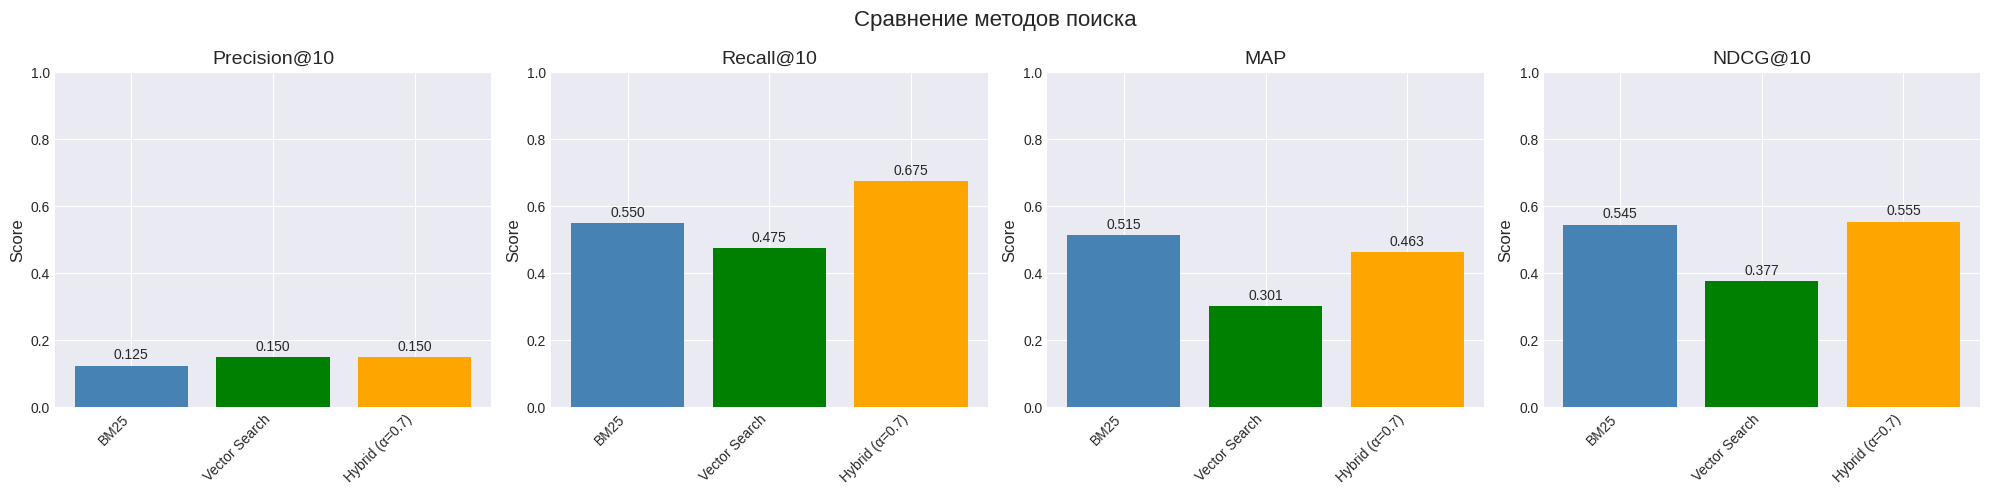

In [ ]:
# Создаём тестовый набор запросов с релевантными документами
# В реальности это должна быть размеченная выборка
hybrid.alpha = 0.6

test_set = [
    {
        "query": "Компьютерное зрение",
        "relevant": [41950, 4671, 45493, 10203, 2958, 7369, 8166, 36750, 15260, 44548]#, 23992]  # ID релевантных документов
    },
    {
        "query": "Стратегия Израильского взаимодействия с Курдистаном",
        "relevant": [237]
    },
    {
        "query": "Отношения древнегреческих полисов между собой",
        "relevant": [13496, 3617]
    },
    {
        "query": "Александр Македонский",
        "relevant": [9826, 8280]
    }
]

def precision_at_k(retrieved: List[int], relevant: List[int], k: int) -> float:
    """Precision@k"""
    retrieved_at_k = retrieved[:k]
    relevant_retrieved = len(set(retrieved_at_k).intersection(set(relevant)))
    return relevant_retrieved / k if k > 0 else 0

def recall_at_k(retrieved: List[int], relevant: List[int], k: int) -> float:
    """Recall@k"""
    retrieved_at_k = retrieved[:k]
    relevant_retrieved = len(set(retrieved_at_k).intersection(set(relevant)))
    return relevant_retrieved / len(relevant) if relevant else 0

def average_precision(retrieved: List[int], relevant: List[int]) -> float:
    """Average Precision"""
    if not relevant:
        return 0

    ap = 0
    relevant_found = 0

    for i, doc_id in enumerate(retrieved, 1):
        if doc_id in relevant:
            relevant_found += 1
            ap += relevant_found / i

    return ap / len(relevant)

def dcg_at_k(retrieved: List[int], relevant: List[int], k: int) -> float:
    """Discounted Cumulative Gain at k"""
    dcg = 0
    for i, doc_id in enumerate(retrieved[:k], 1):
        if doc_id in relevant:
            dcg += 1 / np.log2(i + 1)
    return dcg

def ndcg_at_k(retrieved: List[int], relevant: List[int], k: int) -> float:
    """Normalized Discounted Cumulative Gain at k"""
    if not relevant:
        return 0

    dcg = dcg_at_k(retrieved, relevant, k)

    # Идеальный DCG (все релевантные документы в начале)
    ideal_relevant = relevant[:k]  # Берём только k релевантных документов
    idcg = sum(1 / np.log2(i + 2) for i in range(min(len(relevant), k)))

    return dcg / idcg if idcg > 0 else 0

def evaluate_search_method(search_func, test_set, k=10):
    """Оценка метода поиска"""
    precisions = []
    recalls = []
    aps = []
    ndcgs = []

    for test_case in test_set:
        query = test_case["query"]
        relevant = test_case["relevant"]

        # Получаем результаты поиска
        results = search_func(query, top_k=k)
        retrieved = [doc_id for doc_id, _ in results]

        # Вычисляем метрики
        precisions.append(precision_at_k(retrieved, relevant, k))
        recalls.append(recall_at_k(retrieved, relevant, k))
        aps.append(average_precision(retrieved, relevant))
        ndcgs.append(ndcg_at_k(retrieved, relevant, k))

    return {
        "Precision@10": np.mean(precisions),
        "Recall@10": np.mean(recalls),
        "MAP": np.mean(aps),
        "NDCG@10": np.mean(ndcgs)
    }

# Оцениваем все методы
print("Оценка качества поисковых методов:")
print("=" * 50)

methods = {
    "BM25": lambda q, top_k: bm25.search(q, top_k),
    "Vector Search": lambda q, top_k: vector_search.search(q, top_k),
    "Hybrid (α=0.6)": lambda q, top_k: hybrid.search(q, top_k)
}

results_df = pd.DataFrame()

for method_name, search_func in methods.items():
    metrics = evaluate_search_method(search_func, test_set)
    results_df[method_name] = metrics

# Транспонируем для удобства
results_df = results_df.T
print(results_df.to_string())

# Визуализация результатов
fig, axes = plt.subplots(1, 4, figsize=(20, 5))

for i, metric in enumerate(results_df.columns):
    ax = axes[i]
    values = results_df[metric].values
    methods_list = results_df.index.tolist()

    bars = ax.bar(methods_list, values, color=['steelblue', 'green', 'orange'])
    ax.set_title(metric, fontsize=14)
    ax.set_ylabel('Score', fontsize=12)
    ax.set_ylim(0, 1)

    # Добавляем значения на столбцы
    for bar, value in zip(bars, values):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{value:.3f}', ha='center', va='bottom')

    ax.set_xticklabels(methods_list, rotation=45, ha='right')

plt.suptitle('Сравнение методов поиска', fontsize=16)
plt.tight_layout()
plt.show()

-----

### **8. Оптимизация параметров**

Найдём оптимальные параметры для BM25 и гибридного поиска.

Оптимизация параметров BM25:

Лучшие параметры BM25:
  k1 = 0.5
  b = 1.0
  MAP = 0.5188

Оптимизация параметра α для гибридного поиска:

Лучший параметр α = 0.80
MAP = 0.5146


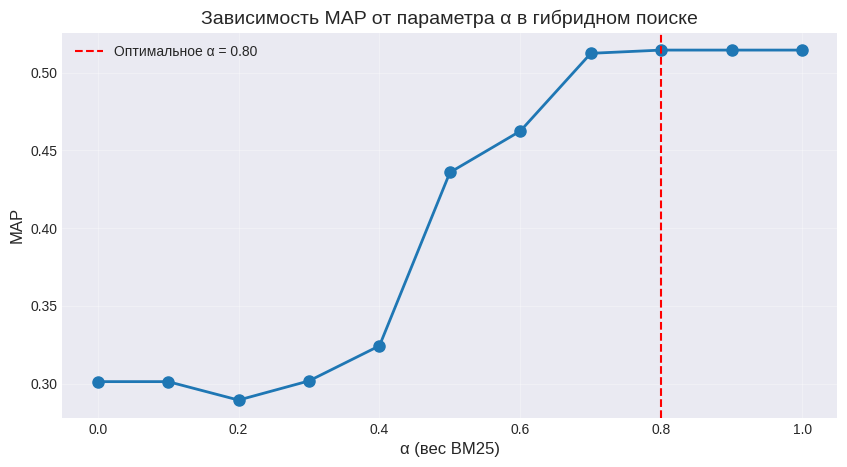

In [ ]:
# Оптимизация параметров BM25
print("Оптимизация параметров BM25:")
print("=" * 50)

k1_values = [0.5, 1.0, 1.2, 1.5, 2.0]
b_values = [0.0, 0.25, 0.5, 0.75, 1.0]

best_map = 0
best_params = {}

for k1 in k1_values:
    for b in b_values:
        # Создаём BM25 с новыми параметрами
        bm25_test = BM25(index, k1=k1, b=b)

        # Оцениваем
        metrics = evaluate_search_method(
            lambda q, top_k: bm25_test.search(q, top_k),
            test_set
        )

        if metrics["MAP"] > best_map:
            best_map = metrics["MAP"]
            best_params = {"k1": k1, "b": b}

print(f"\nЛучшие параметры BM25:")
print(f"  k1 = {best_params['k1']}")
print(f"  b = {best_params['b']}")
print(f"  MAP = {best_map:.4f}")

# Оптимизация alpha для гибридного поиска
print("\n" + "=" * 50)
print("Оптимизация параметра α для гибридного поиска:")

alpha_values = np.linspace(0, 1, 11)
alpha_scores = []

for alpha in alpha_values:
    hybrid.alpha = alpha
    metrics = evaluate_search_method(
        lambda q, top_k: hybrid.search(q, top_k),
        test_set
    )
    alpha_scores.append(metrics["MAP"])

best_alpha_idx = np.argmax(alpha_scores)
best_alpha = alpha_values[best_alpha_idx]

print(f"\nЛучший параметр α = {best_alpha:.2f}")
print(f"MAP = {alpha_scores[best_alpha_idx]:.4f}")

# Визуализация зависимости MAP от alpha
plt.figure(figsize=(10, 5))
plt.plot(alpha_values, alpha_scores, 'o-', linewidth=2, markersize=8)
plt.axvline(best_alpha, color='red', linestyle='--', label=f'Оптимальное α = {best_alpha:.2f}')
plt.xlabel('α (вес BM25)', fontsize=12)
plt.ylabel('MAP', fontsize=12)
plt.title('Зависимость MAP от параметра α в гибридном поиске', fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

-----

### **БЛОК 9: Задания для самостоятельной работы**

Эти задания помогут глубже понять материал и подготовиться к домашней работе.

**ЗАДАНИЯ ДЛЯ САМОСТОЯТЕЛЬНОЙ РАБОТЫ:**


1. **АЛЬТЕРНАТИВНЫЕ ФОРМУЛЫ BM25:**
   - Из библиотеки rank_bm25 попробуйте использовать BM25+ (с дополнительным параметром δ)
   - Из библиотеки rank_bm25 попробуйте использовать BM25-L (с логарифмической нормализацией длины)
   - Сравните качество разных вариантов

2. **УЛУЧШЕНИЕ ВЕКТОРНОГО ПОИСКА:**
   - Попробуйте другие модели (Qwen3-Embedding-8B, FRIDA, multilingual-e5-base)

3. **ИЗУЧЕНИЕ ELASTICSEARCH c TensorFlow-IO:**
   - https://colab.research.google.com/github/tensorflow/io/blob/master/docs/tutorials/elasticsearch.ipynb


-----

### **Заключение**

На этом семинаре мы:
1. ✅ Реализовали BM25 с нуля, включая инвертированный индекс
2. ✅ Создали векторный поиск с помощью Sentence Transformers
3. ✅ Объединили методы в гибридный поиск
4. ✅ Сравнили с готовыми решениями
5. ✅ Оценили качество и оптимизировали параметры

**Ключевые выводы:**
- BM25 отлично работает для точного поиска по ключевым словам
- Векторный поиск лучше для семантического сходства
- Гибридный подход часто даёт лучшие результаты
- Оптимальные параметры зависят от конкретной задачи

**Дополнительные материалы:**
- [Elasticsearch за 30 минут](https://www.youtube.com/watch?v=vxE1aGTEnbE)